In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

# 1. ЗАГРУЗКА ДАННЫХ
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. ДОБАВЛЕНИЕ ЦИКЛИЧЕСКИХ ПРИЗНАКОВ
def add_cyclical_features(df):
    # df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    # df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    # df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    # df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 3. ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ И КАТЕГОРИЙ
# Важно: CatBoost любит, когда категории передаются как int или string
cat_features = [
    'management_group_id', 'first_category_id', 'second_category_id', 
    'third_category_id', 'product_id', 'holiday_flag', 'activity_flag'
]

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'
] + cat_features

# Приводим категориальные признаки к типу int, чтобы CatBoost не ругался
for col in cat_features:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

# 4. ВАЛИДАЦИЯ
max_train_date = train['dt'].max()
val_start_date = max_train_date - pd.Timedelta(days=4)

train_part = train[train['dt'] < val_start_date]
val_part = train[train['dt'] >= val_start_date]

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# Параметры CatBoost
cb_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'MAE', # MAE более устойчив к выбросам в ценах
    'random_seed': 42,
    'verbose': 100,
    'thread_count': -1
}

print("Обучение проверочной модели CatBoost...")
model_low_val = CatBoostRegressor(**cb_params)
model_high_val = CatBoostRegressor(**cb_params)

model_low_val.fit(train_part[features], train_part['price_p05'], cat_features=cat_features)
model_high_val.fit(train_part[features], train_part['price_p95'], cat_features=cat_features)

p_low_val = model_low_val.predict(val_part[features])
p_high_val = model_high_val.predict(val_part[features])
val_score = calculate_iou(val_part['price_p05'], val_part['price_p95'], p_low_val, p_high_val)
print(f"Валидационный IoU (CatBoost): {val_score:.4f}")

# 5. ФИНАЛЬНОЕ ОБУЧЕНИЕ
print("Обучение финальной модели на полном датасете...")
final_model_low = CatBoostRegressor(**cb_params)
final_model_high = CatBoostRegressor(**cb_params)

final_model_low.fit(train[features], train['price_p05'], cat_features=cat_features)
final_model_high.fit(train[features], train['price_p95'], cat_features=cat_features)

# 6. ПРЕДСКАЗАНИЕ ДЛЯ TEST.CSV
print("Создание предсказаний...")
test['price_p05'] = final_model_low.predict(test[features])
test['price_p95'] = final_model_high.predict(test[features])
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

# 7. СОХРАНЕНИЕ SUBMISSION
submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно сохранен!")

Обучение проверочной модели CatBoost...
0:	learn: 0.1444630	total: 170ms	remaining: 2m 49s
100:	learn: 0.0966062	total: 2.69s	remaining: 23.9s
200:	learn: 0.0914754	total: 5.25s	remaining: 20.9s
300:	learn: 0.0886789	total: 7.88s	remaining: 18.3s
400:	learn: 0.0866891	total: 10.6s	remaining: 15.8s
500:	learn: 0.0854507	total: 13.3s	remaining: 13.3s
600:	learn: 0.0841701	total: 16.1s	remaining: 10.7s
700:	learn: 0.0831797	total: 18.7s	remaining: 7.97s
800:	learn: 0.0824058	total: 21.2s	remaining: 5.27s
900:	learn: 0.0816133	total: 23.8s	remaining: 2.62s
999:	learn: 0.0808562	total: 26.3s	remaining: 0us
0:	learn: 0.1002666	total: 24.5ms	remaining: 24.5s
100:	learn: 0.0836107	total: 2.48s	remaining: 22s
200:	learn: 0.0814301	total: 4.94s	remaining: 19.6s
300:	learn: 0.0801077	total: 7.44s	remaining: 17.3s
400:	learn: 0.0789124	total: 9.95s	remaining: 14.9s
500:	learn: 0.0779033	total: 12.6s	remaining: 12.5s
600:	learn: 0.0772246	total: 15.1s	remaining: 10.1s
700:	learn: 0.0765257	total: 1

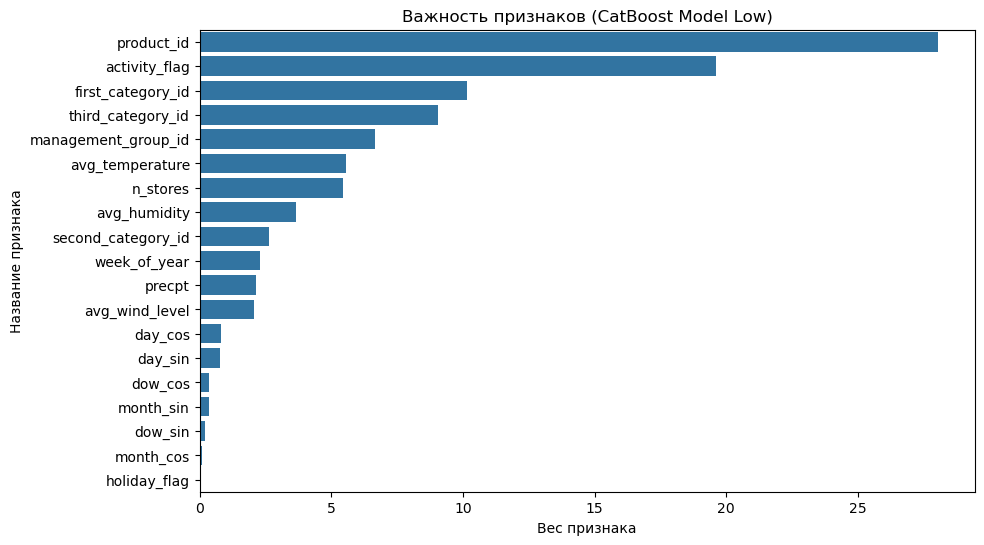

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_model_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

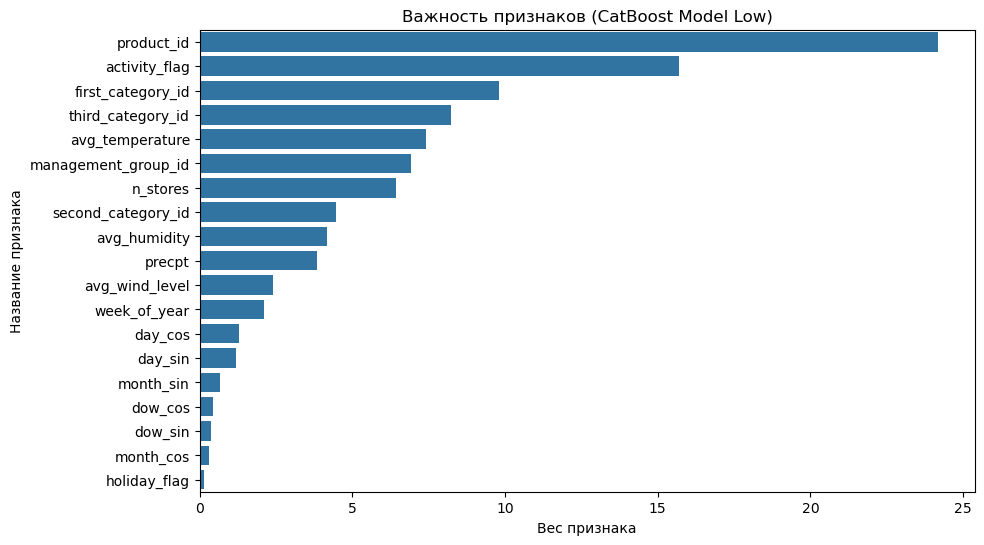

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_model_high.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

# K-means

In [13]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 0. МЕТРИКА
def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# Функция для создания только нужных признаков (day_sin/cos)
def add_cyclical_features(df):
    # Создаем признаки на основе дня месяца (как ты и хотел)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    return df

# 1. ЗАГРУЗКА ДАННЫХ
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# ПРИМЕНЯЕМ функцию создания признаков (исправляет твою ошибку KeyError)
train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 2. КЛАСТЕРИЗАЦИЯ ТОВАРОВ
print("Кластеризация товаров по поведению цен...")
# Используем p95 для определения динамики
pivot_train = train.pivot_table(index='product_id', columns='dt', values='price_p95').fillna(0)

# Нормализация для сравнения формы графиков
scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_train.T).T 

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
product_clusters = kmeans.fit_predict(pivot_scaled)

cluster_dict = dict(zip(pivot_train.index, product_clusters))

train['cluster_id'] = train['product_id'].map(cluster_dict).fillna(-1).astype(int)
test['cluster_id'] = test['product_id'].map(cluster_dict).fillna(-1).astype(int)
print(f"Товары распределены по {n_clusters} кластерам.")

# 3. ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ (без слабых фичей по твоему списку)
cat_features = [
    'management_group_id', 'first_category_id', 'second_category_id', 
    'third_category_id', 'product_id', 'activity_flag', 'cluster_id'
]

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year', 'day_sin', 'day_cos'
] + cat_features

# Приводим категории к int
for col in cat_features:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

# ... (весь код до пункта 4 остается таким же) ...

# 4. ВАЛИДАЦИЯ (для поиска оптимального количества итераций)
max_train_date = train['dt'].max()
val_start_date = max_train_date - pd.Timedelta(days=4)

train_part = train[train['dt'] < val_start_date]
val_part = train[train['dt'] >= val_start_date]

cb_params = {
    'iterations': 2000, # Даем запас
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'MAE', 
    'random_seed': 42,
    'verbose': 0, # Чтобы не заспамить экран при двойном обучении
    'early_stopping_rounds': 100
}

print("Шаг 1: Поиск лучших итераций на валидации...")
tmp_low = CatBoostRegressor(**cb_params).fit(
    train_part[features], train_part['price_p05'], 
    eval_set=(val_part[features], val_part['price_p05']), 
    cat_features=cat_features, use_best_model=True
)
tmp_high = CatBoostRegressor(**cb_params).fit(
    train_part[features], train_part['price_p95'], 
    eval_set=(val_part[features], val_part['price_p95']), 
    cat_features=cat_features, use_best_model=True
)

best_iter_low = tmp_low.get_best_iteration()
best_iter_high = tmp_high.get_best_iteration()

print(f"Лучшие итерации: Low={best_iter_low}, High={best_iter_high}")

# 5. ФИНАЛЬНОЕ ОБУЧЕНИЕ НА ВСЕМ ДАТАСЕТЕ
print("Шаг 2: Переобучение моделей на полном датасете (Re-fit)...")

final_model_low = CatBoostRegressor(
    **{**cb_params, 'iterations': best_iter_low + 1, 'early_stopping_rounds': None}
)
final_model_high = CatBoostRegressor(
    **{**cb_params, 'iterations': best_iter_high + 1, 'early_stopping_rounds': None}
)

# Учим на train целиком, включая те 4 дня, что были в валидации
final_model_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_model_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 6. ПРЕДСКАЗАНИЕ И СОХРАНЕНИЕ
print("\nСоздание финальных предсказаний для теста...")
test['price_p05'] = final_model_low.predict(test[features])
test['price_p95'] = final_model_high.predict(test[features])

# Пост-процессинг
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission_final.csv', index=False)
print("Готово! Модели увидели весь датасет.")

Кластеризация товаров по поведению цен...
Товары распределены по 5 кластерам.
Шаг 1: Поиск лучших итераций на валидации...


C:\Users\MadBoss\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Лучшие итерации: Low=1773, High=955
Шаг 2: Переобучение моделей на полном датасете (Re-fit)...
0:	learn: 0.1479883	total: 29.6ms	remaining: 52.6s
100:	learn: 0.0986383	total: 2.84s	remaining: 47s
200:	learn: 0.0950000	total: 5.77s	remaining: 45.2s
300:	learn: 0.0924518	total: 8.78s	remaining: 43s
400:	learn: 0.0903639	total: 11.7s	remaining: 40.2s
500:	learn: 0.0889707	total: 14.7s	remaining: 37.4s
600:	learn: 0.0878514	total: 17.8s	remaining: 34.8s
700:	learn: 0.0868367	total: 20.9s	remaining: 32s
800:	learn: 0.0860327	total: 23.8s	remaining: 28.9s
900:	learn: 0.0852873	total: 26.8s	remaining: 26s
1000:	learn: 0.0846424	total: 29.8s	remaining: 23s
1100:	learn: 0.0840540	total: 32.9s	remaining: 20.1s
1200:	learn: 0.0835576	total: 36s	remaining: 17.2s
1300:	learn: 0.0830445	total: 38.9s	remaining: 14.1s
1400:	learn: 0.0825846	total: 41.9s	remaining: 11.1s
1500:	learn: 0.0821909	total: 44.8s	remaining: 8.15s
1600:	learn: 0.0818483	total: 47.8s	remaining: 5.17s
1700:	learn: 0.0814657	tota

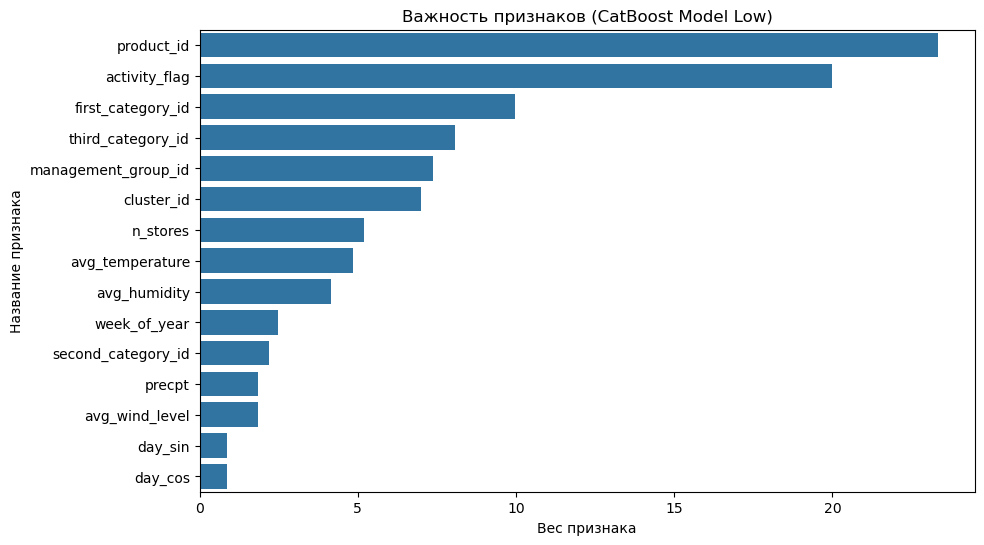

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_model_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

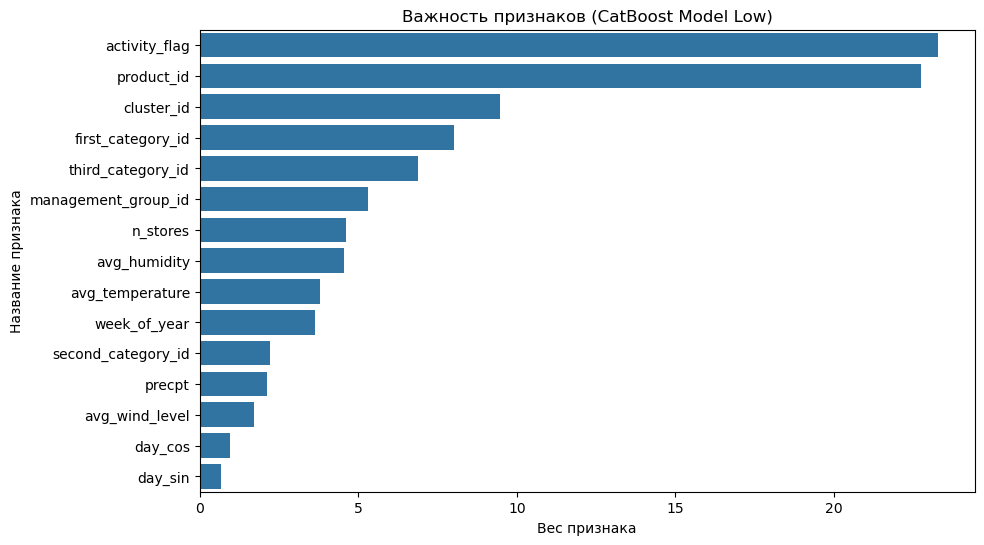

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_model_high.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

In [17]:
train_part['cluster_id'].value_counts()

cluster_id
0    7810
1    6215
3    5940
2    4840
4    1870
Name: count, dtype: int64